In [218]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable


from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

# Telescope Pointing Simulation

Lets first create a simple reference list of sky positions for an AltAz system. For now, lets make the distance between each point  (Az and Alt)  to be 20 degree.

In [107]:
x      = np.arange(5, 95,20)
y      = np.arange(5, 95,20)
mx, my = np.meshgrid(x, y)
plist  = np.vstack([mx.ravel(), my.ravel()])

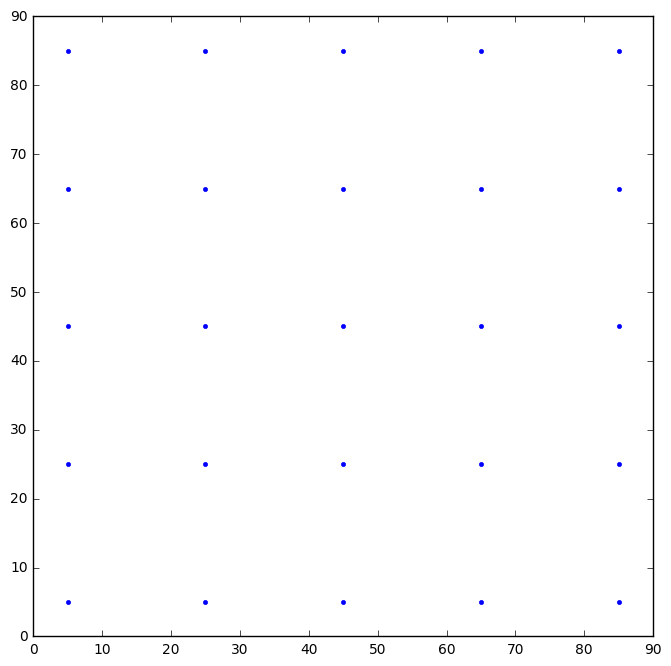

In [109]:

def plot_stuff(plist): 
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.plot(plist[0],plist[1], ".");
    ax.set_xlim([0,90])
    ax.set_ylim([0,90])
    plt.show()

plot_stuff(plist)

# add offset function

lets add an offset depending on the elevation.

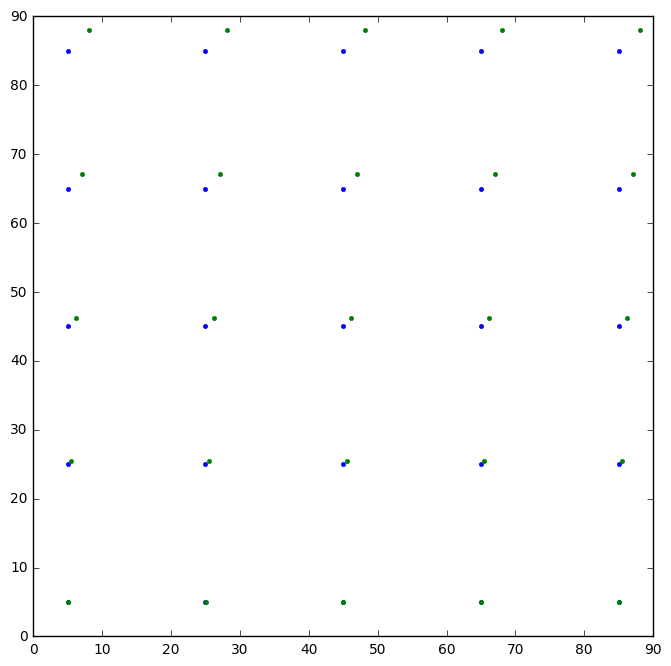

In [119]:
def yoff(p,y):
    return p+((y/40.)**1.5)

Xf, Yf  = yoff(mx,my), yoff(my,my)
plist1  = np.vstack([Xf.ravel(), Yf.ravel()])

def plot_stuff_off(plist): 
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    for i in plist:
        ax.plot(i[0],i[1], ".");
    ax.set_xlim([0,90])
    ax.set_ylim([0,90])
    plt.show()
plot_stuff_off([plist,plist1])

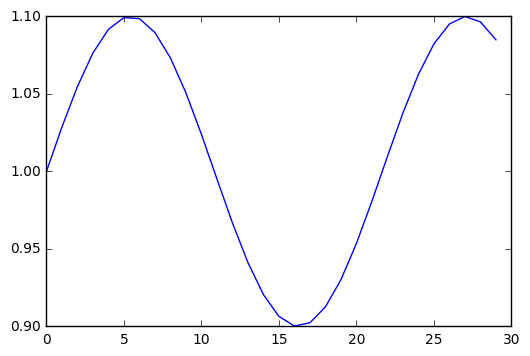

In [179]:
t = np.arange(0.,30.)

def t_x_response(t):
    return np.sin(t*t.max()/100.)*.1+1.#*np.sin(t*t.max()/20.)

def t_y_response(t):
    return np.sin(t*t.max()/100.)*np.sin(t*t.max()/10.)*.1+1.

plt.plot(t,t_response(t))
plt.show()

apply temperature response

In [180]:
tempx = t_x_response(t)
tempy = t_y_response(t)
parr = np.asarray([np.ones((temp.shape[0],plist1.shape[1]))*plist1[0],np.ones((temp.shape[0],plist1.shape[1]))*plist1[1]])
parrt= np.asarray([parr[0].T* tempx, parr[1].T * tempy])
print parrt.shape

(2, 25, 30)


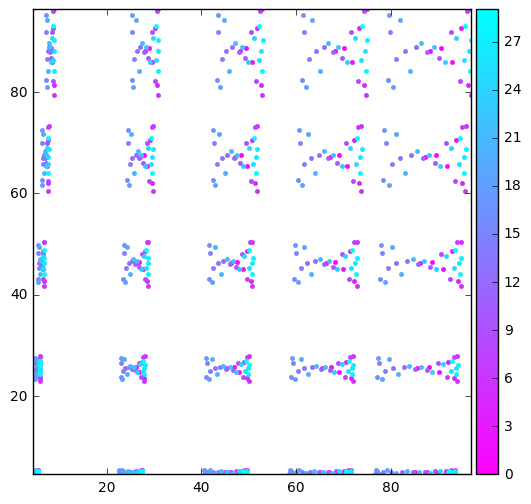

In [202]:
def colorscale(XY):
    norm = matplotlib.colors.Normalize(vmin=XY.min(),vmax=XY.max() )
    c_m  = matplotlib.cm.cool_r
    s_m  = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
    s_m.set_array([])
    return s_m

def plot_stuff_temp(plist, t): 
    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111)
    s_m = colorscale(t)
    for i in range(t.shape[0]):
        ax.plot(plist[0,:,i],plist[1,:,i], ".", color=s_m.to_rgba(t[i]));
    ax.set_xlim([plist[0].min(),plist[0].max()])
    ax.set_ylim([plist[1].min(),plist[1].max()])
    
    cax1  = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
    cbar  = plt.colorbar(s_m,  cax= cax1)
    
    plt.show()

plot_stuff_temp(parrt,t)

# lets make some predictions, taking a single position

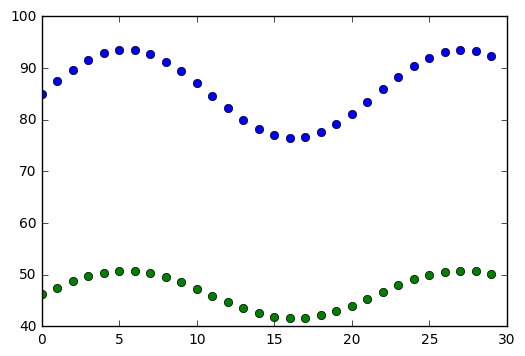

In [215]:
### lets choose two points
P1 = parrt[0,4]
P2 = parrt[0,12]

plt.plot(t,P1,"bo")
plt.plot(t,P2,"go")
plt.show()

In [220]:
# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), cv=5, param_grid=param_grid)

In [221]:
stime = time.time()
kr.fit(t, P1)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

/usr/local/Cellar/python/HEAD/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 24]